In [72]:
import json
import os
import pickle
import keras
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.signal import savgol_filter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, BatchNormalization, Dense, Dropout, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [73]:



def trim_start_end_nans(df):
    """
    Removes rows at the start and end of a DataFrame that have NaN values in any column.
    """
    # Initialize start_idx and end_idx based on the DataFrame's index type
    if isinstance(df.index, pd.DatetimeIndex):
        start_idx = df.index[0]  # Assume first index is earliest; adjust if necessary
        end_idx = df.index[-1]  # Assume last index is latest; adjust if necessary
    else:
        start_idx = 0
        end_idx = len(df) - 1

    for column in df.columns:
        # Find the first non-NaN index in the current column
        first_valid_index = df[column].first_valid_index()
        if first_valid_index is not None and df.index.get_loc(
            first_valid_index
        ) > df.index.get_loc(start_idx):
            start_idx = first_valid_index

        # Find the last non-NaN index in the current column
        last_valid_index = df[column].last_valid_index()
        if last_valid_index is not None and df.index.get_loc(
            last_valid_index
        ) < df.index.get_loc(end_idx):
            end_idx = last_valid_index

    # Trim the DataFrame
    return df.loc[start_idx:end_idx]




def process_data_for_plot(
    plot_number,
    target_columns,
    continuous_columns,
    start_date="2023-07-20",
    end_date="2023-09-03",
    rolling_windows=[3, 7], 
):
    """
    Process data for a given plot number within a specified date range. This includes:
    * Spike Detection (up and down) for VWC columns
    * Time since last significant precipitation
    * Cumulative precipitation within a time window
    * Rolling window statistics
    * Time Encoding
    """

    # Database connection
    conn = sqlite3.connect("processed_data.db")
    query = "SELECT * FROM data_table"
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Filter by plot_number and date range
    df = df[
        (df["plot_number"] == plot_number)
        & (df["TIMESTAMP"] >= start_date)
        & (df["TIMESTAMP"] <= end_date)
    ]

    # Convert TIMESTAMP to datetime
    df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
    df.set_index("TIMESTAMP", inplace=True)

    # Sort by TIMESTAMP 
    df.sort_values(by="TIMESTAMP", inplace=True)

    # Select relevant columns
    df = df[continuous_columns + target_columns]

    # Resample to daily frequency 
    df = df.resample("D").mean()

    # Spike detection for VWC columns
    for col in df.columns:
        if "VWC" in col:
            df[f"{col}_spike_up"] = (df[col] > df[col].shift(1) * 1.15).astype(int)  # 15% increase
            df[f"{col}_spike_down"] = (df[col] < df[col].shift(1) * 0.85).astype(int)  # 15% decrease

    # Time features
    df['time_index'] = np.arange(len(df))

    # Time since precipitation (modify thresholds as needed)
    significant_precip_threshold = 0.5  
    max_precip_value = df['precip_irrig'].max()
    df['time_since_last_significant_precip'] = (df['precip_irrig'] > significant_precip_threshold).astype(int)
    df['time_since_last_significant_precip'] = df['time_since_last_significant_precip'].replace(to_replace=0, method='ffill')
    df['time_since_last_half_max_precip'] = (df['precip_irrig'] > (max_precip_value / 2)).astype(int)
    df['time_since_last_half_max_precip'] = df['time_since_last_half_max_precip'].replace(to_replace=0, method='ffill')

    # Cumulative precipitation (replace 4 with the desired window)
    df['precip_irrig_cumulative_4day'] = df['precip_irrig'].rolling(4).sum() 

    # Preprocessing 
    df = df.interpolate(method="pchip")

    # Rolling window features
    for window in rolling_windows:
        for col in continuous_columns:
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
            df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()

    return df

In [74]:
def subtract_mean(df, target_columns, continuous_columns):
    # Subtract mean from each column (append new columns with suffix "_mean_subtracted")
    df_mean_subtracted = df.copy()
    mean_values = {}
    for col in df_mean_subtracted.columns:
        if col in [target_columns + continuous_columns]:
            mean_values[col] = df_mean_subtracted[col].mean()
            df_mean_subtracted[col] = df_mean_subtracted[col] - mean_values[col]
    return df_mean_subtracted, mean_values

def create_derivative_columns(df, target_columns, continuous_columns):
    initial_values = {}
    for col in df.columns:  # Change to apply to all columns
        if col in [target_columns + continuous_columns]:
            initial_values[col] = df[col].iloc[0]
        deriv_col_name = f"{col}_deriv" 
        df[deriv_col_name] = df[col].diff().fillna(0)  # Fill NaN with 0 for initial diff
    return df, initial_values


def transform_and_scale_data(df, target_columns, continuous_columns):
    df_transformed = df.copy()
    df_transformed, mean_values = subtract_mean(df_transformed, target_columns, continuous_columns)  # Change here to apply to all
    df_transformed, initial_values = create_derivative_columns(df_transformed, target_columns, continuous_columns)
    df_transformed["precip_irrig_bool"] = df_transformed["precip_irrig"].apply(
        lambda x: 1 if x > 0 else 0
    )
    
    
    return df_transformed



In [75]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import os
import pickle

def train_and_save_model_with_time_series_validation(X, y, forecast_day, model_save_path):
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Best model placeholder
    best_model = None
    best_rmse = float("inf")

    # Iterate over each train-test split
    for train_index, val_index in tscv.split(X):
        # Split data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Prepare DMatrices
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        # XGBoost parameters
        param = {
        'max_depth': 3,
        'eta': 0.05, 
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'subsample': 0.8,
        'colsample_bytree': 1, 
        'lambda': 1,
        'alpha': 0.2,
        'gamma': 0.2 
    }


        num_round = 5000  # Number of training iterations

        # Train XGBoost model with early stopping
        bst = xgb.train(
            param,
            dtrain,
            num_round,
            [(dtrain, 'train'), (dval, 'val')],
            early_stopping_rounds=500,
            verbose_eval=True
        )

        # Predict on validation set
        y_val_pred = bst.predict(dval)

        # Calculate RMSE for the current split
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        print(f"Validation RMSE for current split: {val_rmse:.2f}")

        # Update best model if improvement
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_model = bst

    # Save the best model using pickle
    best_model_save_path = os.path.join(model_save_path, f"best_model_day_{forecast_day}.pkl")
    os.makedirs(os.path.dirname(best_model_save_path), exist_ok=True)

    with open(best_model_save_path, 'wb') as file:
        pickle.dump(best_model, file)

    return best_model_save_path


c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
[0]	train-rmse:17.79192	val-rmse:24.89868
[1]	train-rmse:17.03437	val-rmse:24.14389
[2]	train-rmse:16.29370	val-rmse:23.40608
[3]	train-rmse:15.56330	val-rmse:22.67865
[4]	train-rmse:14.86585	val-rmse:21.98421
[5]	train-rmse:14.20924	val-rmse:21.33056
[6]	train-rmse:13.58448	val-rmse:20.70877
[7]	train-rmse:12.99607	val-rmse:20.12330
[8]	train-rmse:12.41453	val-rmse:19.54479
[9]	train-rmse:11.90309	val-rmse:19.03614
[10]	train-rmse:11.38134	val-rmse:18.51735
[11]	train-rmse:10.89563	val-rmse:18.03451
[12]	train-rmse:10.42929	val-rmse:17.57104
[13]	train-rmse:9.96333	val-rmse:17.10804
[14]	train-rmse:9.51942	val-rmse:16.66705
[15]	train-rmse:9.09428	val-rmse:16.24480
[16]	train-rmse:8.70337	val-rmse:15.85661
[17]	train-rmse:8.31720	val-rmse:15.47321
[18]	train-rmse:7.94836	val-rmse:15.10707
[19]	train-rmse:7.60248	val-rmse:14.76376
Validation RMSE for current split: 

C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_12848\3537817959.py:90: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['time_since_last_significant_precip'] = df['time_since_last_significant_precip'].replace(to_replace=0, method='ffill')
C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_12848\3537817959.py:92: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['time_since_last_half_max_precip'] = df['time_since_last_half_max_precip'].replace(to_replace=0, method='ffill')
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarnin

[5]	train-rmse:16.46505	val-rmse:12.64479
[6]	train-rmse:15.71666	val-rmse:11.88139
[7]	train-rmse:14.98546	val-rmse:11.13404
[8]	train-rmse:14.28546	val-rmse:10.41700
[9]	train-rmse:13.64303	val-rmse:9.75734
[10]	train-rmse:13.02106	val-rmse:9.11702
[11]	train-rmse:12.43412	val-rmse:8.51103
[12]	train-rmse:11.86675	val-rmse:8.06738
[13]	train-rmse:11.32116	val-rmse:7.64464
[14]	train-rmse:10.82304	val-rmse:7.23486
[15]	train-rmse:10.36204	val-rmse:6.75637
[16]	train-rmse:9.89986	val-rmse:6.27496
[17]	train-rmse:9.45242	val-rmse:5.93087
[18]	train-rmse:9.04854	val-rmse:5.62001
[19]	train-rmse:8.64616	val-rmse:5.31444
Validation RMSE for current split: 5.31
[0]	train-rmse:20.23224	val-rmse:16.68509
[1]	train-rmse:19.26966	val-rmse:15.70960
[2]	train-rmse:18.35169	val-rmse:14.77804
[3]	train-rmse:17.49278	val-rmse:13.90509
[4]	train-rmse:16.68899	val-rmse:13.08682
[5]	train-rmse:15.91154	val-rmse:12.29394
[6]	train-rmse:15.17114	val-rmse:11.53733
[7]	train-rmse:14.46640	val-rmse:10.81557

c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[2]	train-rmse:18.35169	val-rmse:14.77804
[3]	train-rmse:17.49278	val-rmse:13.90509
[4]	train-rmse:16.68899	val-rmse:13.08682
[5]	train-rmse:15.91154	val-rmse:12.29394
[6]	train-rmse:15.17114	val-rmse:11.53733
[7]	train-rmse:14.46640	val-rmse:10.81557
[8]	train-rmse:13.78287	val-rmse:10.11381
[9]	train-rmse:13.15129	val-rmse:9.46364
[10]	train-rmse:12.55565	val-rmse:8.84114
[11]	train-rmse:12.01114	val-rmse:8.27845
[12]	train-rmse:11.46430	val-rmse:7.70700
[13]	train-rmse:10.94397	val-rmse:7.16515
[14]	train-rmse:10.43502	val-rmse:6.62337
[15]	train-rmse:9.95912	val-rmse:6.21810
[16]	train-rmse:9.50678	val-rmse:5.72337
[17]	train-rmse:9.08288	val-rmse:5.28439
[18]	train-rmse:8.66038	val-rmse:4.85005
[19]	train-rmse:8.28067	val-rmse:4.42984
Validation RMSE for current split: 4.43
Model for day 2 trained and saved for plot 2001
[0]	train-rmse:17.79192	val-rmse:24.89868
[1]	train-rmse:17.03437	val-rmse:24.14389
[2]	train-rmse:16.29370	val-rmse:23.40608
[3]	train-rmse:15.56330	val-rmse:22.

c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[19]	train-rmse:7.60248	val-rmse:14.76376
Validation RMSE for current split: 14.76
[0]	train-rmse:20.75246	val-rmse:22.88294
[1]	train-rmse:19.79645	val-rmse:21.91200
[2]	train-rmse:18.89592	val-rmse:20.99597
[3]	train-rmse:18.03589	val-rmse:20.11961
[4]	train-rmse:17.20285	val-rmse:19.26912
[5]	train-rmse:16.44219	val-rmse:18.49089
[6]	train-rmse:15.70758	val-rmse:17.73760
[7]	train-rmse:15.01169	val-rmse:17.02222
[8]	train-rmse:14.35475	val-rmse:16.34504
[9]	train-rmse:13.74851	val-rmse:15.71826
[10]	train-rmse:13.13538	val-rmse:15.08227
[11]	train-rmse:12.57106	val-rmse:14.49478
[12]	train-rmse:12.02804	val-rmse:13.92720
[13]	train-rmse:11.59312	val-rmse:13.47079
[14]	train-rmse:11.10704	val-rmse:12.95847
[15]	train-rmse:10.66289	val-rmse:12.48799
[16]	train-rmse:10.23404	val-rmse:12.05143
[17]	train-rmse:9.82360	val-rmse:11.50057
[18]	train-rmse:9.41352	val-rmse:11.08707
[19]	train-rmse:9.04317	val-rmse:10.59965
Validation RMSE for current split: 10.60
[0]	train-rmse:21.34676	val-r

c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_12848\3537817959.py:90: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['time_since_last_significant_precip'] = df['time_since_last_significant_precip'].replace(to_replace=0, method='ffill')
C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_12848\3537817959.py:92: F

Models path for day 1: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 2: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 3: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 4: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models


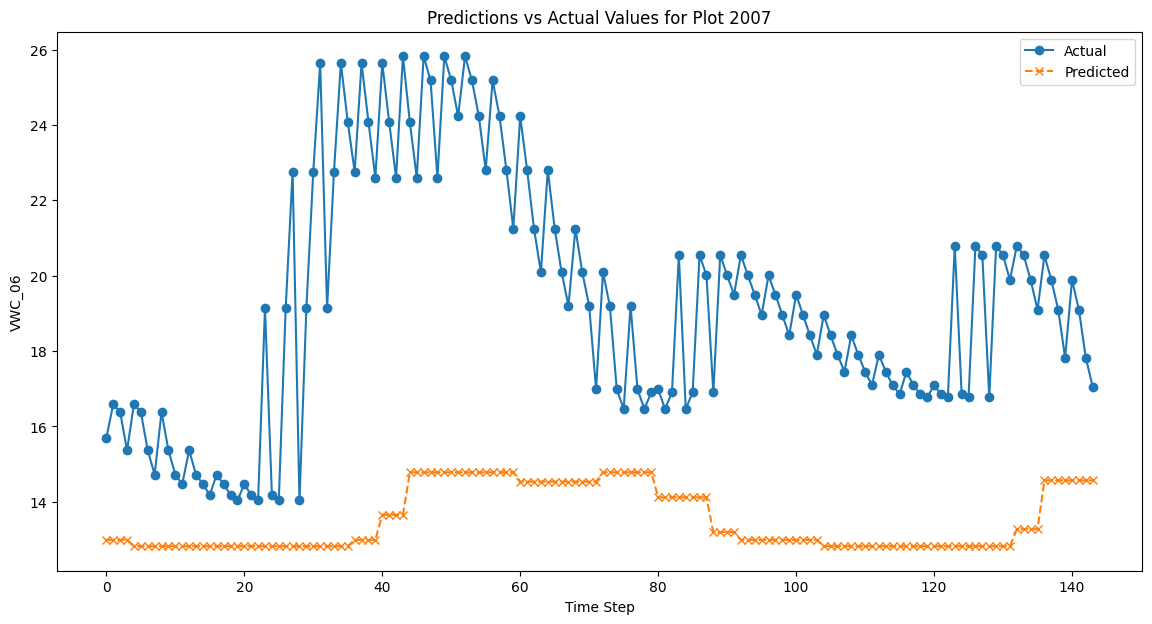

[[12.9916544  12.9916544  12.9916544  12.9916544 ]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.9916544  12.9916544  12.9916544  12.9916544 ]
 [13.65489674 13.65489674 13.65489674 13.65489674]
 [14.78283501 14.78283501 14.78283501 14.78283501]
 [14.78283501 14.78283501 14.78283501 14.78283501]
 [14.78283501 14.78283501 14.78283501 14.78283501]
 [14.78283501 14.78283501 14.78283501 14.78283501]
 [14.53538132 14.53538132 14.53538132 14.53538132]
 [14.53538132 14.53538132 14.53538132 14.53538132]
 [14.53538132 14.53538132 14.53538132 14.53538132]
 [14.78283501 14.78283501 14.78283501 14.78283501]
 [14.78283501 14.78283501 14.78

In [76]:
import pandas as pd
import numpy as np
import os
import sqlite3
import pickle
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# Assuming the necessary functions are defined as provided: 
# trim_start_end_nans, process_data_for_plot, subtract_mean, create_derivative_columns, transform_and_scale_data




def prepare_and_train_models(plot_numbers, target_column, continuous_columns, forecast_horizon, model_save_path):
    """
    Prepare data, train models for each forecast horizon, and save the models.
    """
    for plot_number in plot_numbers:
        # Process and transform data
        df = process_data_for_plot(plot_number, [target_column], continuous_columns)
        df = trim_start_end_nans(df)
        df_transformed = transform_and_scale_data(df, [target_column], continuous_columns)

        # Define training data
        X = df_transformed.drop(columns=[target_column]).values
        y = df_transformed[target_column].values

        # Train and save model for each forecast horizon
        for forecast_day in range(1, forecast_horizon + 1):  # Example: 3-day forecast horizon
            train_and_save_model_with_time_series_validation(X, y, forecast_day, model_save_path)
            print(f"Model for day {forecast_day} trained and saved for plot {plot_number}")

def predict_with_model(model_path, X):
    """
    Load a model from a file and make predictions.
    """
    
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
        
    dtest = xgb.DMatrix(X)
    return model.predict(dtest)


def run_inference(models_path, plot_number, target_column, continuous_columns, forecast_horizon):
    # Process and transform data for inference
    df = process_data_for_plot(plot_number, [target_column], continuous_columns)
    df = trim_start_end_nans(df)
    df_transformed = transform_and_scale_data(df, [target_column], continuous_columns)

    X = df_transformed.drop(columns=[target_column]).values
    y_actual = df_transformed[target_column].values

    predictions = np.zeros((len(X) - forecast_horizon + 1, forecast_horizon))

    for day in range(1, forecast_horizon + 1):
        model_path = os.path.join(models_path, f"best_model_day_{day}.pkl")
        print(f"Models path for day {day}: {models_path}")
        pred = predict_with_model(model_path, X[:-(forecast_horizon - day) if (forecast_horizon - day) > 0 else None])
        for i in range(min(len(pred), len(predictions))):
            predictions[i, day - 1] = pred[i]

    # Filter out rows where all values are zero (assuming zero predictions are not expected)
    predictions = predictions[~np.all(predictions == 0, axis=1)]

    # Flatten predictions and actuals to plot on the same curve
    flat_predictions = predictions.flatten()
    # Adjust actuals to match the length of filtered predictions
    adjusted_length = len(flat_predictions) // forecast_horizon
    flat_actuals = np.array([y_actual[i:i+forecast_horizon] for i in range(adjusted_length)]).flatten()

    # Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(flat_actuals, label='Actual', linestyle='-', marker='o')
    plt.plot(flat_predictions, label='Predicted', linestyle='--', marker='x')

    plt.title(f'Predictions vs Actual Values for Plot {plot_number}')
    plt.xlabel('Time Step')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()

    return predictions


# Example usage
plot_numbers = [2001]  # Example plot numbers for training
target_column = "VWC_06"
continuous_columns = [
    "Ta_2m_Avg", "RH_2m_Avg", "Solar_2m_Avg", "WndAveSpd_3m", "Rain_1m_Tot",
    "Dp_2m_Avg", "TaMax_2m", "TaMin_2m", "RHMax_2m", "RHMin_2m",
    "HeatIndex_2m_Avg", "irrigation", "precip_irrig", "canopy_temp",
    "VWC_18", "VWC_30"
]

model_save_path = os.path.join(os.getcwd(), "models") 

print(model_save_path)
forecast_horizon = 4

# Train models
prepare_and_train_models(plot_numbers, target_column, continuous_columns, forecast_horizon, model_save_path)

# Inference
plot_number_for_inference = 2007  # Example plot number for inference
predictions = run_inference(model_save_path, plot_number_for_inference, target_column, continuous_columns, forecast_horizon)
print(predictions)


C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_12848\3537817959.py:90: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['time_since_last_significant_precip'] = df['time_since_last_significant_precip'].replace(to_replace=0, method='ffill')
C:\Users\bnsoh2\AppData\Local\Temp\ipykernel_12848\3537817959.py:92: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['time_since_last_half_max_precip'] = df['time_since_last_half_max_precip'].replace(to_replace=0, method='ffill')


Models path for day 1: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 2: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 3: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models
Models path for day 4: c:\Users\bnsoh2\OneDrive - University of Nebraska-Lincoln\Projects\Students\Bryan Nsoh\Indep_study_NsohGuo_2024\ML\models


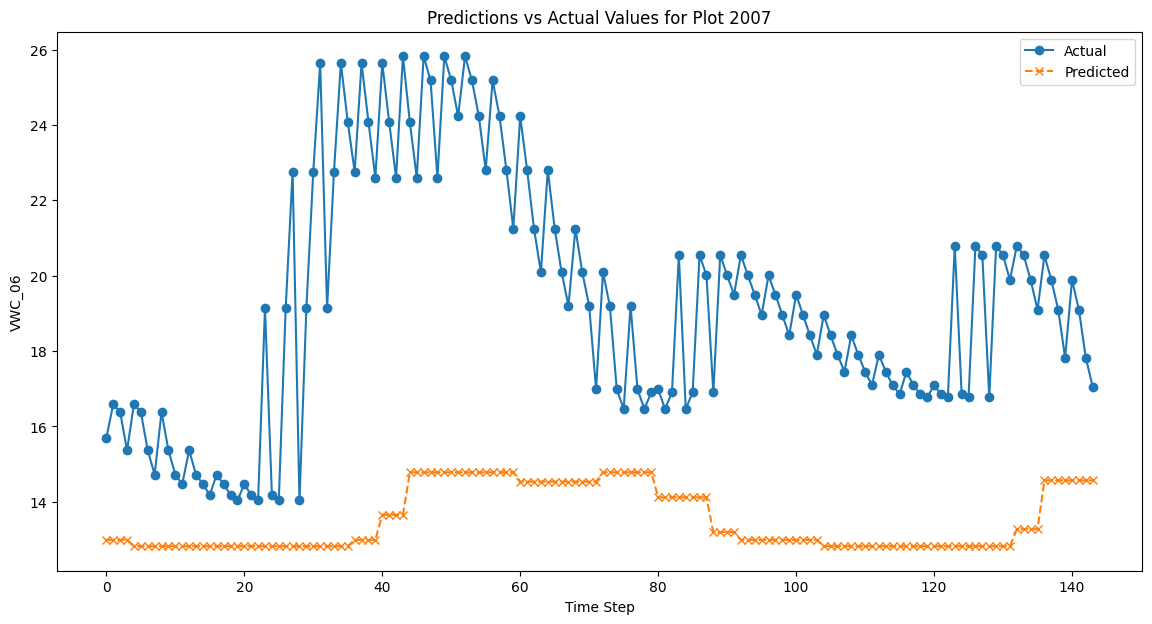

[[12.9916544  12.9916544  12.9916544  12.9916544 ]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.82194233 12.82194233 12.82194233 12.82194233]
 [12.9916544  12.9916544  12.9916544  12.9916544 ]
 [13.65489674 13.65489674 13.65489674 13.65489674]
 [14.78283501 14.78283501 14.78283501 14.78283501]
 [14.78283501 14.78283501 14.78283501 14.78283501]
 [14.78283501 14.78283501 14.78283501 14.78283501]
 [14.78283501 14.78283501 14.78283501 14.78283501]
 [14.53538132 14.53538132 14.53538132 14.53538132]
 [14.53538132 14.53538132 14.53538132 14.53538132]
 [14.53538132 14.53538132 14.53538132 14.53538132]
 [14.78283501 14.78283501 14.78283501 14.78283501]
 [14.78283501 14.78283501 14.78

In [77]:
# Inference
plot_number_for_inference = 2007  # Example plot number for inference
predictions = run_inference(model_save_path, plot_number_for_inference, target_column, continuous_columns, forecast_horizon)
print(predictions)
